In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# Подготовка датасета

In [197]:
def writeToFile(dataset_test, Id_col, model, model_name, flag_exp = False):
  if flag_exp:
      res = pd.DataFrame(np.expm1(model.predict(dataset_test)))
  else:
      res = pd.DataFrame(model.predict(dataset_test))  
  res.columns=['SalePrice']
  res = pd.concat([Id_col.Id,res], axis=1).set_index('Id')
  res.to_csv('house_submission_'+model_name+'.csv')

In [3]:
dataset_train = pd.read_csv("/content/drive/MyDrive/datasets/train.csv")
dataset_test = pd.read_csv("/content/drive/MyDrive/datasets/test.csv")

In [4]:
dataset_test_Id = pd.read_csv("/content/drive/MyDrive/datasets/test.csv")

In [5]:
dataset_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


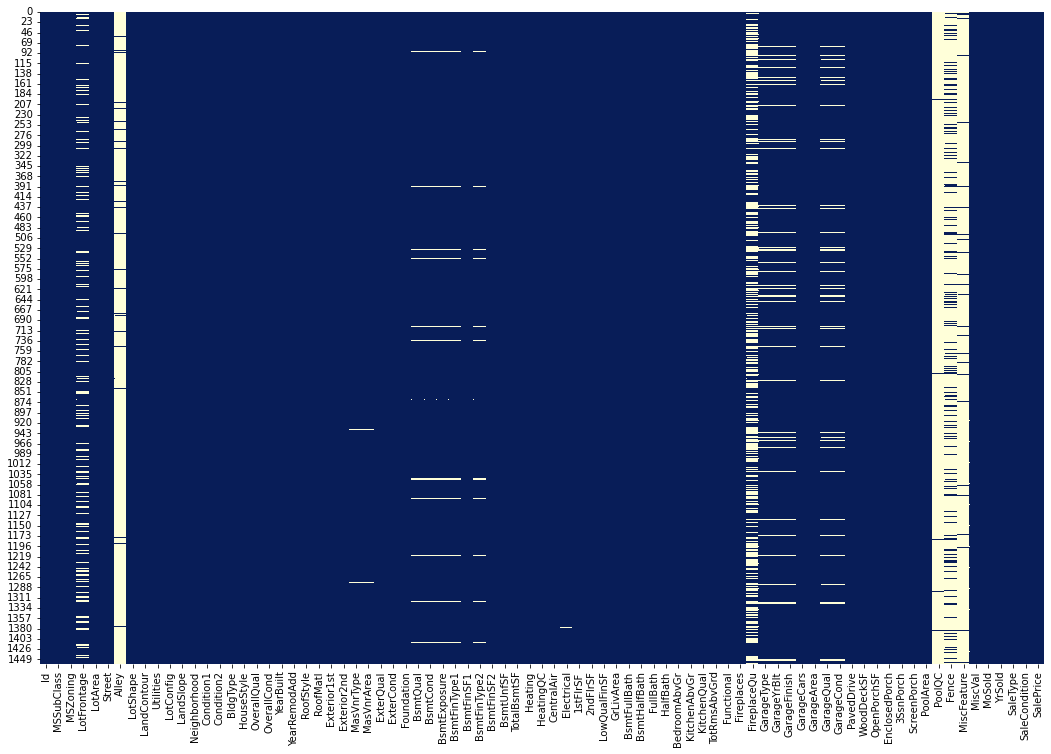

In [6]:
# есть пустые значения, поэтому построим график 
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(dataset_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [7]:
# удалим колонки с почти пустыми данными и колонку Id
dataset_train.drop(columns=['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],inplace=True)
dataset_test.drop(columns=['Id','PoolQC','Fence','MiscFeature','FireplaceQu','Alley'],inplace=True)

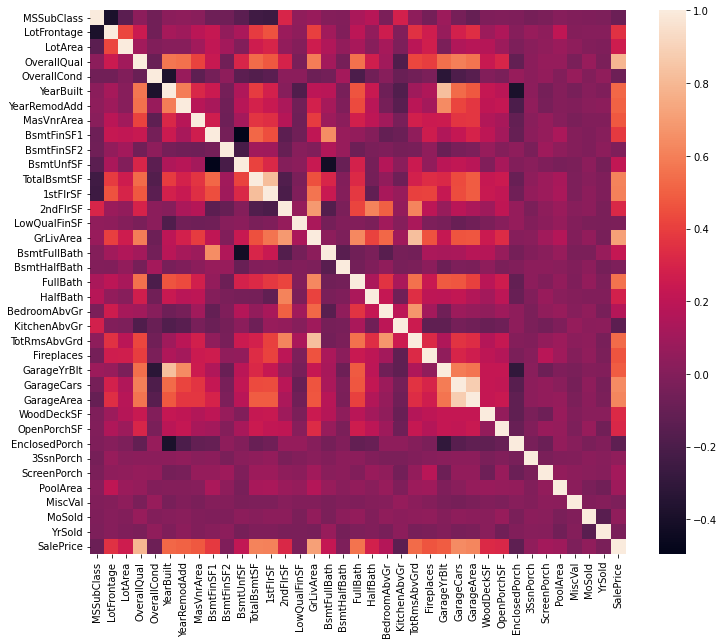

In [8]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(dataset_train.corr())
plt.show()

In [9]:
# corr = dataset_train.corr()
# corr_arr = np.asarray(corr)

In [10]:
# feachures = corr.columns

In [11]:
# # Получим коррелирующие признаки
# for corr_i in range(len(corr_arr)):
#     for corr_j in range(corr_i,len(corr_arr[corr_i])):
#         if abs(corr_arr[corr_i][corr_j]) > 0.75 and abs(corr_arr[corr_i][corr_j]) != 1 and corr_i!=corr_j:
#             if feachures[corr_i] != 'SalePrice' and feachures[corr_j] != 'SalePrice':
#                 print(feachures[corr_i],feachures[corr_j],corr_arr[corr_i][corr_j])
#                 # посчитаем у кого больше корреляция с таргетом:
#                 print(corr[feachures[corr_i]].SalePrice)
#                 print(corr[feachures[corr_j]].SalePrice)
#                 print('-----------------')

In [12]:
# # видны корреляции:
# # TotalBsmtSF 1stFlrSF
# # YearBuilt GarageYrBlt
# # GrLivArea TotRmsAbvGrd
# # GarageCars GarageArea
# # будем дропать фичу, у которой корреляция с таргетом меньше, исходя из полученных ранее данных
# dataset_train.drop(columns=['GarageYrBlt','1stFlrSF','TotRmsAbvGrd','GarageArea'],inplace=True)
# dataset_test.drop(columns=['GarageYrBlt','1stFlrSF','TotRmsAbvGrd','GarageArea'],inplace=True)

In [13]:
# посмотрим на список уникальных значений по каждому столбцу типа object
# в которых есть nan
for_plot = []
for col in dataset_train.select_dtypes(include='object').columns:
    unic_tmp = dataset_train[col]
    if unic_tmp.isnull().any():
        print(col,unic_tmp.unique())
        for_plot.append(col)        

MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


In [14]:
# удалим все значения с типом nan, но до этого посмотрим, сколько строк у датасета
print(dataset_train.shape)
print(dataset_train.dropna().shape)
# теряется достаточно много данных, поэтому с этим надо что-то делать

(1460, 75)
(1094, 75)


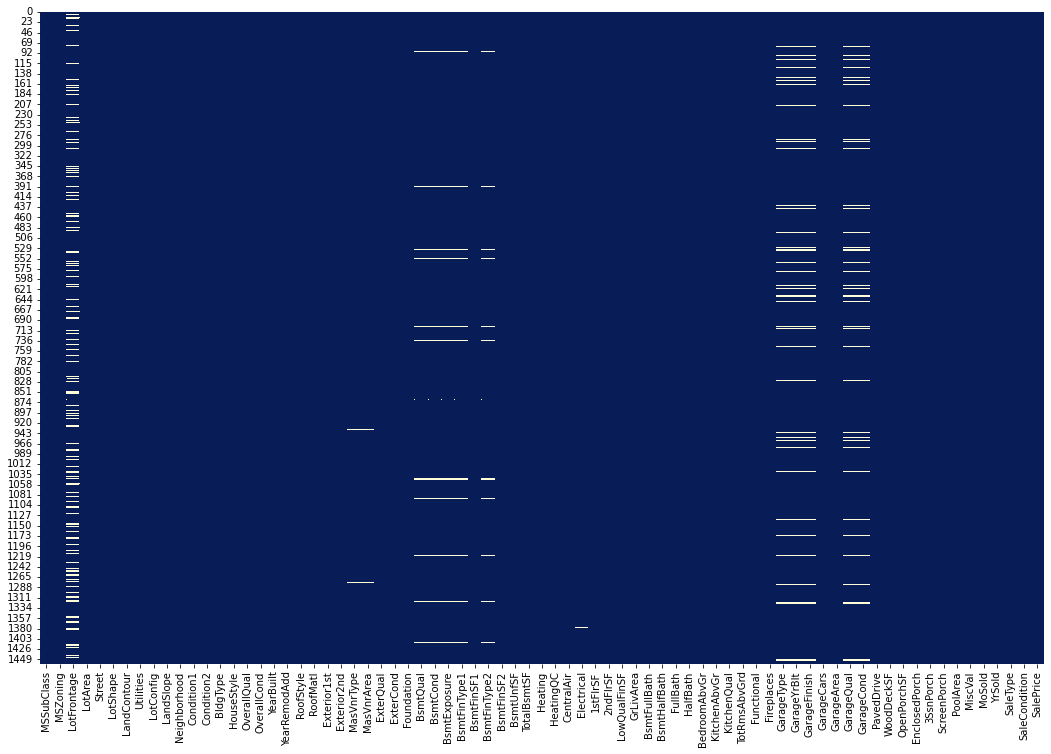

In [15]:
# построим еще раз график нулевых значений 
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(dataset_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [16]:
def fillna_mean(dataset,column_name):
    dataset[column_name] = dataset[column_name].fillna(dataset[~dataset[column_name].isnull()][column_name].mean())

In [17]:
# заполним пустые значения по LotFrontage средним по всему столбцу
fillna_mean(dataset_train,'LotFrontage')
fillna_mean(dataset_test,'LotFrontage')

In [18]:
dataset_train.LotFrontage.unique()

array([ 65.        ,  80.        ,  68.        ,  60.        ,
        84.        ,  85.        ,  75.        ,  70.04995837,
        51.        ,  50.        ,  70.        ,  91.        ,
        72.        ,  66.        , 101.        ,  57.        ,
        44.        , 110.        ,  98.        ,  47.        ,
       108.        , 112.        ,  74.        , 115.        ,
        61.        ,  48.        ,  33.        ,  52.        ,
       100.        ,  24.        ,  89.        ,  63.        ,
        76.        ,  81.        ,  95.        ,  69.        ,
        21.        ,  32.        ,  78.        , 121.        ,
       122.        ,  40.        , 105.        ,  73.        ,
        77.        ,  64.        ,  94.        ,  34.        ,
        90.        ,  55.        ,  88.        ,  82.        ,
        71.        , 120.        , 107.        ,  92.        ,
       134.        ,  62.        ,  86.        , 141.        ,
        97.        ,  54.        ,  41.        ,  79.  

In [19]:
dataset_train[~dataset_train.LotFrontage.isnull()].shape

(1460, 75)

In [20]:
# удалим все значения с типом nan, но до этого посмотрим, сколько строк у датасета
print(dataset_train.shape)
print(dataset_train.dropna().shape)
# теперь, если удалить пустые - потеряется 122 записи, что уже не столь критично
# поэтому удалим пустые значения

(1460, 75)
(1338, 75)


In [21]:
# еще раз посмотрим на список уникальных значений по каждому столбцу, где есть nan
# и попробуем понять, чем можно заменить nan
for_plot = []
for col in dataset_train.select_dtypes(include='object').columns:
    unic_tmp = dataset_train[col]
    if unic_tmp.isnull().any():
        print(col,unic_tmp.unique())
        for_plot.append(col)

MasVnrType ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtCond ['TA' 'Gd' nan 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' nan]
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageFinish ['RFn' 'Unf' 'Fin' nan]
GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
GarageCond ['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


In [22]:
dataset_train.MasVnrType.fillna('None',inplace=True)

In [23]:
dataset_test.MasVnrType.fillna('None',inplace=True)

In [24]:
for_plot.append('SalePrice')

In [25]:
dataset_for_corr = dataset_train[for_plot].dropna()

In [26]:
dataset_for_corr.head()

,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageFinish,GarageQual,GarageCond,SalePrice
0,BrkFace,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA,208500
1,None,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,RFn,TA,TA,181500
2,BrkFace,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA,223500
3,None,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,Unf,TA,TA,140000
4,BrkFace,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA,250000


In [27]:
dataset_for_corr.shape

(1346, 12)

In [28]:
# в новом датасете для поиска корреляции - с помощью labelEncoding перекодируем признаки
le = LabelEncoder()
for col in for_plot:
    dataset_for_corr[col] = le.fit_transform(dataset_for_corr[col])

In [29]:
# выведем вектор корреляции признаков с ценой и отметим, 
# что больше всего корреляции имеют столбцы BsmtQual, GarageType и GarageFinish
# остальные признаки имеют корреляцию близку к нулю, поэтому их удалим
# а с оставшимися двумя будем решать, что делать с пропущенными значениями
# я бы заполнил их медианным значением
corr_array = dataset_for_corr.corr().SalePrice
corr_array

MasVnrType      0.014634
BsmtQual       -0.589485
BsmtCond        0.058061
BsmtExposure   -0.284474
BsmtFinType1   -0.047834
BsmtFinType2    0.060371
Electrical      0.251636
GarageType     -0.441106
GarageFinish   -0.570252
GarageQual      0.159077
GarageCond      0.177233
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [30]:
drop_ = [col for i,col in enumerate(for_plot) if abs(corr_array[i]) < 0.5]

In [31]:
drop_

['MasVnrType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageQual',
 'GarageCond']

In [32]:
dataset_train.drop(columns=drop_,axis=1,inplace=True)
dataset_test.drop(columns=drop_,axis=1,inplace=True)

In [33]:
# еще раз посмотрим на список уникальных значений по каждому столбцу, где есть nan
# и попробуем понять, чем можно заменить nan
for_plot = []
for col in dataset_train.select_dtypes(include='object').columns:
    unic_tmp = dataset_train[col]
    if unic_tmp.isnull().any():
        print(col,unic_tmp.unique())
        for_plot.append(col)

BsmtQual ['Gd' 'TA' 'Ex' nan 'Fa']
GarageFinish ['RFn' 'Unf' 'Fin' nan]


In [34]:
# заполним медианным значением
dataset_train.BsmtQual.fillna(dataset_train.BsmtQual.value_counts().idxmax(),inplace=True)
dataset_test.BsmtQual.fillna(dataset_test.BsmtQual.value_counts().idxmax(),inplace=True)
dataset_train.GarageFinish.fillna(dataset_train.GarageFinish.value_counts().idxmax(),inplace=True)
dataset_test.GarageFinish.fillna(dataset_test.GarageFinish.value_counts().idxmax(),inplace=True)

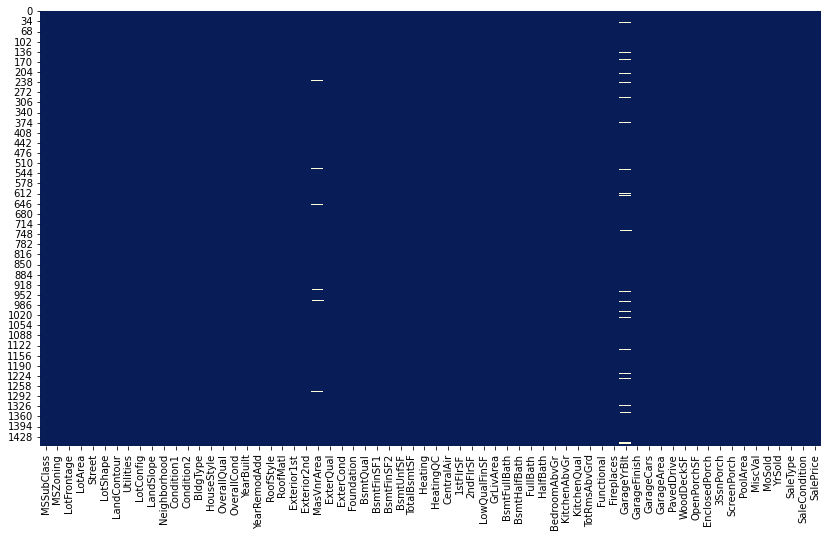

In [35]:
# построим еще раз график нулевых значений 
fig, ax = plt.subplots(figsize=(14,8))
sns.heatmap(dataset_train.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [36]:
# посмотрим на список уникальных значений по каждому столбцу типа float, где есть nan
for col in dataset_train.select_dtypes(include='float').columns:
    unic_tmp = dataset_train[col]
    if unic_tmp.isnull().any():
        print(col)

MasVnrArea
GarageYrBlt


In [37]:
# заполним пустые значения по GarageYrBlt и MasVnrArea средним по всему столбцу
fillna_mean(dataset_train,'GarageYrBlt')
fillna_mean(dataset_test,'GarageYrBlt')
fillna_mean(dataset_train,'MasVnrArea')
fillna_mean(dataset_test,'MasVnrArea')

In [38]:
# в тестовом датасете остались пропуски, заполним их средним
for col in dataset_test.select_dtypes(include='float').columns:
    unic_tmp = dataset_test[col]
    if unic_tmp.isnull().any():
        fillna_mean(dataset_test,col)

In [39]:
for col in dataset_train.select_dtypes(include='object').columns:
    dataset_train[col] = le.fit_transform(dataset_train[col])

In [40]:
for col in dataset_test.select_dtypes(include='object').columns:
    unic_tmp = dataset_test[col]
    if unic_tmp.isnull().any():
        dataset_test[col].fillna(dataset_test[col].value_counts().idxmax(),inplace=True)

In [41]:
for col in dataset_test.select_dtypes(include='object').columns:
    dataset_test[col] = le.fit_transform(dataset_test[col])

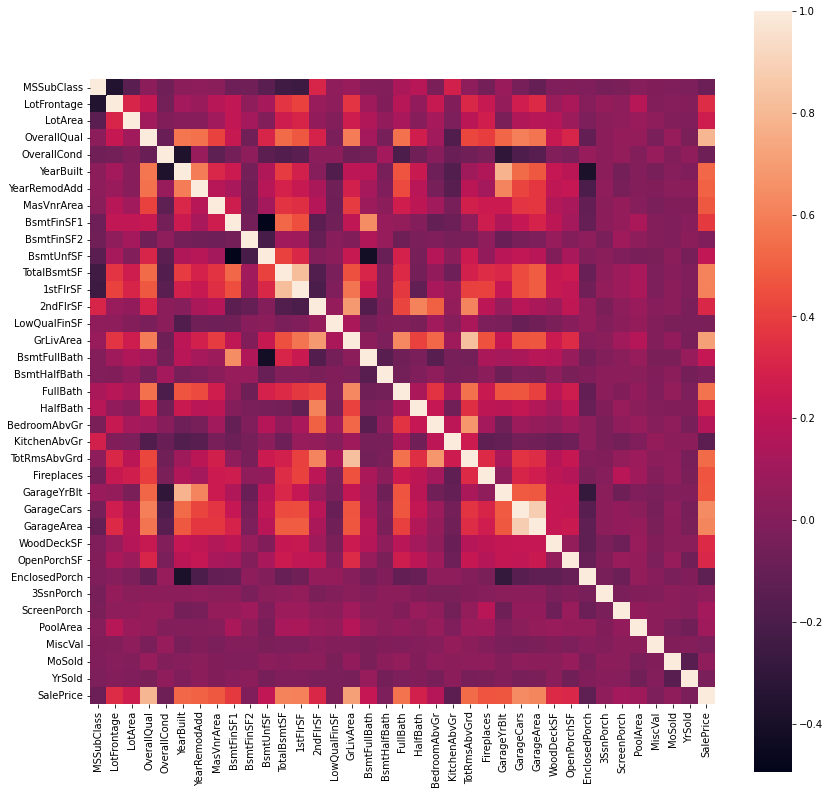

In [ ]:
fig = plt.figure(figsize=(14,14))
sns.heatmap(dataset_train.corr(),square=True)

In [ ]:
dataset_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,Gd,706,0,150,856,GasA,Ex,Y,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,2003.0,RFn,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,Gd,978,0,284,1262,GasA,Ex,Y,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,1976.0,RFn,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,Gd,486,0,434,920,GasA,Ex,Y,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,2001.0,RFn,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,TA,216,0,540,756,GasA,Gd,Y,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,1998.0,Unf,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,Gd,655,0,490,1145,GasA,Ex,Y,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,2000.0,RFn,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


# XGBoost

In [183]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [184]:
# xg_reg = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=500, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xg_reg = xgb.XGBRegressor()

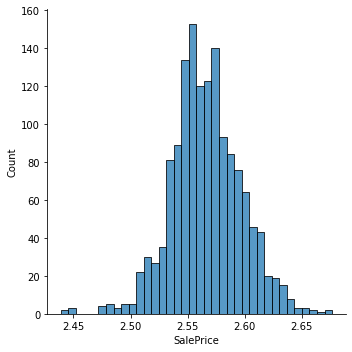

In [185]:
# отлогорифмируем таргет, чтобы он имел нормальное распределение,
# для предсказаний - возьмем в экспоненту
dataset_train["SalePrice"] = np.log1p(dataset_train["SalePrice"])
sns.displot(dataset_train['SalePrice'])

In [186]:
X = dataset_train.drop(columns=['SalePrice'],axis=1)
y = dataset_train.SalePrice

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.3, 0.5, 0.7],
              # 'colsample_bytree': [0.3, 0.5, 0.6],
              'colsample_bytree':[0.5], 
              'colsample_bylevel':[0.5], 
              'colsample_bynode':[0.5],
              'n_estimators': [1000]}

xgb_grid = GridSearchCV(xg_reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [149]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


GridSearchCV(cv=2, estimator=XGBRegressor(), n_jobs=5,
             param_grid={'colsample_bylevel': [0.5], 'colsample_bynode': [0.5],
                         'colsample_bytree': [0.5],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [1000], 'nthread': [4],
                         'objective': ['reg:squarederror'], 'silent': [1],
                         'subsample': [0.3, 0.5, 0.7]},
             verbose=True)

In [188]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.8930261317598549
{'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.5}


In [189]:
print(xgb_grid.best_score_)

0.8930261317598549


In [63]:
xgb_grid.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=5,
             min_child_weight=3, n_estimators=1000, nthread=4,
             objective='reg:squarederror', silent=1, subsample=0.7)

In [113]:
xgb_grid.best_estimator_

XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=5,
             min_child_weight=4, n_estimators=1000, nthread=4,
             objective='reg:squarederror', silent=1, subsample=0.7)

In [190]:
preds = xgb_grid.predict(X_test)

In [191]:
preds.shape

(292,)

In [192]:
X_test.shape

(292, 65)

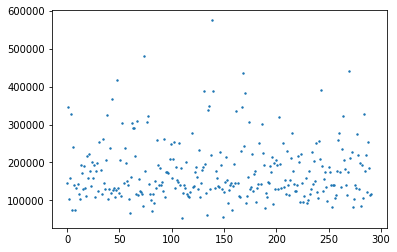

In [154]:
plt.scatter([i for i in range(len(preds))],np.expm1(preds),s=2)

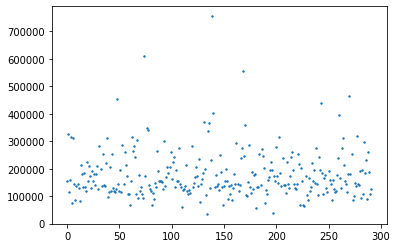

In [156]:
plt.scatter([i for i in range(len(y_test))],np.expm1(y_test),s=2)

In [157]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.130637


In [159]:
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(preds)))
print("RMSE: %f" % (rmse))

RMSE: 25410.541235


In [160]:
xgb_grid.best_estimator_.score(X_test,y_test)

0.9085478790837673

In [138]:
xgb_grid.best_estimator_.score(X_test,y_test)

0.9162064708547336

In [193]:
preds = xgb_grid.predict(dataset_test)

In [198]:
writeToFile(dataset_test, dataset_test_Id, xgb_grid.best_estimator_, 'xgboost_log_target', True)

# Feature selecting

In [ ]:
features = xgb_grid.best_estimator_.feature_importances_

In [ ]:
len(dataset_test.columns)

65

In [ ]:
len(features)

65

In [ ]:
ll = []
counter = 0
for feat, name in zip(features,dataset_test.columns):
    ll.append([feat, name])

In [ ]:
arr = np.asarray(ll)

In [ ]:
top_30 = arr[arr[:,0].astype(float).argsort()][-30:]

In [ ]:
top_30_feat = []
for elem in top_30:
    top_30_feat.append(elem[1])

In [ ]:
top_30_feat_tr = top_30_feat
top_30_feat_tr.append('SalePrice')

In [ ]:
top_30_feat

['OverallCond',
 'GarageArea',
 'LotArea',
 'Condition2',
 'LandSlope',
 'RoofMatl',
 'YearBuilt',
 'Neighborhood',
 'TotRmsAbvGrd',
 'YearRemodAdd',
 'MSZoning',
 'GarageFinish',
 'LandContour',
 'HalfBath',
 'PoolArea',
 '1stFlrSF',
 'Heating',
 'BsmtFinSF1',
 '2ndFlrSF',
 'CentralAir',
 'TotalBsmtSF',
 'Fireplaces',
 'KitchenQual',
 'GrLivArea',
 'KitchenAbvGr',
 'FullBath',
 'BsmtQual',
 'ExterQual',
 'GarageCars',
 'OverallQual']

In [ ]:
top_30_feat_test = top_30_feat

In [ ]:
dataset_train_new = dataset_train[top_30_feat_tr]

In [ ]:
dataset_test_new = dataset_test[top_30_feat]

In [ ]:
dataset_test_new.head()

,OverallCond,GarageArea,LotArea,Condition2,LandSlope,RoofMatl,YearBuilt,Neighborhood,TotRmsAbvGrd,YearRemodAdd,MSZoning,GarageFinish,LandContour,HalfBath,PoolArea,1stFlrSF,Heating,BsmtFinSF1,2ndFlrSF,CentralAir,TotalBsmtSF,Fireplaces,KitchenQual,GrLivArea,KitchenAbvGr,FullBath,BsmtQual,ExterQual,GarageCars,OverallQual
0,6,730.0,11622,2,0,0,1961,12,5,1961,2,2,3,0,0,896,0,468.0,0,1,882.0,0,3,896,1,1,3,3,1.0,5
1,6,312.0,14267,2,0,0,1958,12,6,1958,3,2,3,1,0,1329,0,923.0,0,1,1329.0,0,2,1329,1,1,3,3,1.0,6
2,5,482.0,13830,2,0,0,1997,8,6,1998,3,0,3,1,0,928,0,791.0,701,1,928.0,1,3,1629,1,2,2,3,2.0,5
3,6,470.0,9978,2,0,0,1998,8,7,1998,3,0,3,1,0,926,0,602.0,678,1,926.0,1,2,1604,1,2,3,3,2.0,6
4,5,506.0,5005,2,0,0,1992,22,5,1992,3,1,1,0,0,1280,0,263.0,0,1,1280.0,0,2,1280,1,2,2,2,2.0,8


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
X_new = SelectKBest(chi2, k=30).fit_transform(X,y)

In [ ]:
X_new

array([[6.000e+01, 6.500e+01, 8.450e+03, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [2.000e+01, 8.000e+01, 9.600e+03, ..., 0.000e+00, 0.000e+00,
        5.000e+00],
       [6.000e+01, 6.800e+01, 1.125e+04, ..., 0.000e+00, 0.000e+00,
        9.000e+00],
       ...,
       [7.000e+01, 6.600e+01, 9.042e+03, ..., 0.000e+00, 2.500e+03,
        5.000e+00],
       [2.000e+01, 6.800e+01, 9.717e+03, ..., 0.000e+00, 0.000e+00,
        4.000e+00],
       [2.000e+01, 7.500e+01, 9.937e+03, ..., 0.000e+00, 0.000e+00,
        6.000e+00]])

In [ ]:
xgb_grid.best_estimator_.score(X_train,y_train)

0.999250900500717

In [ ]:
xgb_grid.best_estimator_.score(X_test,y_test)

0.9035584093299229

In [ ]:
xgb_grid.best_estimator_.score(X_test,y_test)

0.8891510310975772

In [ ]:
xg_reg.score(X_test,y_test)

0.8941627276687081

In [ ]:
xg_reg.predict(dataset_test)

array([123889.78, 160169.28, 179767.06, ..., 174953.55, 113329.59,
       225499.25], dtype=float32)

In [ ]:
dataset_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,10,12,0.0,3,4,1,3,468.0,144.0,270.0,882.0,0,4,1,896,0,0,896,0.0,0.0,1,0,2,1,3,5,6,0,1961.0,2,1.0,730.0,2,140,0,0,0,120,0,0,6,2010,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,11,13,108.0,3,4,1,3,923.0,0.0,406.0,1329.0,0,4,1,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,6,0,1958.0,2,1.0,312.0,2,393,36,0,0,0,0,12500,6,2010,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,10,12,0.0,3,4,2,2,791.0,0.0,137.0,928.0,0,2,1,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,6,1,1997.0,0,2.0,482.0,2,212,34,0,0,0,0,0,3,2010,8,4
3,60,3,78.0,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,10,12,20.0,3,4,2,3,602.0,0.0,324.0,926.0,0,0,1,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,6,1,1998.0,0,2.0,470.0,2,360,36,0,0,0,0,0,6,2010,8,4
4,120,3,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,0.0,2,4,2,2,263.0,0.0,1017.0,1280.0,0,0,1,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,6,0,1992.0,1,2.0,506.0,2,0,82,0,0,144,0,0,1,2010,8,4


# Линейная регрессия

In [65]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [66]:
dataset_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'

In [67]:
lin_reg = LinearRegression(normalize=True)

In [68]:
X = dataset_train.drop(columns=['SalePrice'],axis=1)
y = dataset_train['SalePrice']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

In [71]:
fitted_lin_reg = model.fit(X,y)

In [72]:
fitted_lin_reg.score(X_test,y_test)

0.8773716579382966

In [73]:
fitted_lin_reg.score(X_train,y_train)

0.8377771140301489

In [175]:
preds = fitted_lin_reg.predict(dataset_test)

In [ ]:
writeToFile(dataset_test, dataset_test_Id, lin_reg, 'lin_reg')

# Случайный лес

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [199]:
X = dataset_train.drop(columns=['SalePrice'],axis=1)
y = dataset_train['SalePrice']

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
forest_reg = RandomForestRegressor()
parameters = {'n_estimators':[25,30],'max_depth':[3,5,6,8,10],'min_samples_leaf':[1,5,10],'min_samples_split':[2,5,10]}

In [205]:
CV = KFold(n_splits=5, random_state=42, shuffle=True)
srch = GridSearchCV(forest_reg,parameters,cv=CV)

In [206]:
srch.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 30]})

In [79]:
srch.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=25)

In [207]:
srch.best_estimator_.score(X_train,y_train)

0.97172558981351

In [81]:
srch.best_estimator_.score(X_test,y_test)

0.8819389592773639

In [ ]:
writeToFile(dataset_test, dataset_test_Id, srch.best_estimator_, "forest_new_n_est=30")

# CatBoost regression

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [84]:
from catboost import CatBoostRegressor

In [93]:
model = CatBoostRegressor()

In [103]:
parameters = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
catgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [104]:
fitted = catgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
0:	learn: 74704.0621497	total: 2.48ms	remaining: 493ms
1:	learn: 70428.9370162	total: 5.22ms	remaining: 516ms
2:	learn: 66311.0812786	total: 7.44ms	remaining: 488ms
3:	learn: 62655.5414571	total: 9.59ms	remaining: 470ms
4:	learn: 59385.2385324	total: 11.7ms	remaining: 457ms
5:	learn: 56197.7874229	total: 13.8ms	remaining: 447ms
6:	learn: 53243.6557557	total: 15.9ms	remaining: 439ms
7:	learn: 50691.8239949	total: 18.4ms	remaining: 441ms
8:	learn: 48490.3438088	total: 20.5ms	remaining: 435ms
9:	learn: 46437.5209614	total: 22.7ms	remaining: 430ms
10:	learn: 44479.7348609	total: 24.8ms	remaining: 427ms
11:	learn: 42844.3221412	total: 26.9ms	remaining: 422ms
12:	learn: 41348.7103806	total: 29.2ms	remaining: 420ms
13:	learn: 39824.2920822	total: 31.3ms	remaining: 416ms
14:	learn: 38572.7940880	total: 33.5ms	remaining: 413ms
15:	learn: 37607.3520988	total: 35.6ms	remaining: 410ms
16:	learn: 36288.6166920	total: 37.7ms	remaining: 40

In [107]:
catgb_grid.best_estimator_.score(X_train,y_train)

0.9732626820203294

In [108]:
catgb_grid.best_estimator_.score(X_test,y_test)

0.9020786165928129

In [109]:
writeToFile(dataset_test, dataset_test_Id, catgb_grid.best_estimator_, "catboost_cv")